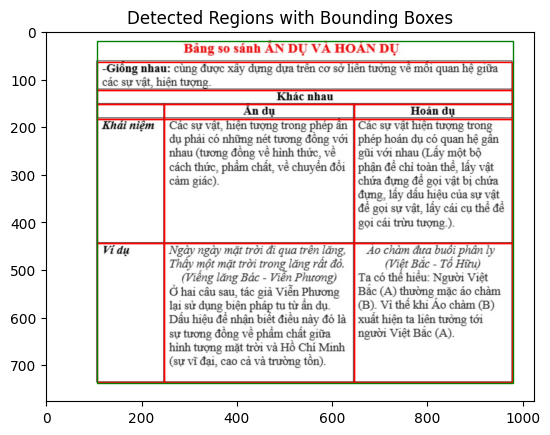

In [24]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from docx import Document

# Đọc ảnh và chuyển sang grayscale
img = cv2.imread('table.jpg', cv2.IMREAD_GRAYSCALE)

# Áp dụng threshold để chuyển ảnh thành đen trắng
_, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

# Kernel cho đường ngang và dọc (dùng cho bảng)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))

# Tìm các đường ngang và dọc (phát hiện bảng)
horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# Kết hợp các đường ngang và dọc để phát hiện bảng
table_area = cv2.add(horizontal_lines, vertical_lines)

# Tìm các contours để phân chia bảng
contours, hierarchy = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lưu các bounding box của contours
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# Loại bỏ contour lớn nhất (toàn bộ bảng lớn)
max_contour = max(bounding_boxes, key=lambda b: b[2] * b[3])
bounding_boxes = [b for b in bounding_boxes if b != max_contour]

# Tạo mặt nạ để che đi các vùng chứa bảng
mask = np.ones(binary_img.shape, dtype=np.uint8) * 255
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(mask, (x, y), (x + w, y + h), 0, -1)

# Áp dụng mặt nạ để giữ lại các vùng không phải bảng (vùng đoạn văn)
non_table_area = cv2.bitwise_and(binary_img, binary_img, mask=mask)

# Sử dụng kỹ thuật Morphology để tìm các vùng đoạn văn
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))  # Điều chỉnh kernel để phù hợp với văn bản
text_area = cv2.morphologyEx(non_table_area, cv2.MORPH_CLOSE, kernel)

# Tìm các contours của vùng đoạn văn
text_contours, _ = cv2.findContours(text_area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lọc và sắp xếp các contours theo thứ tự từ trên xuống dưới và từ trái sang phải
bounding_boxes_text = [cv2.boundingRect(c) for c in text_contours]
bounding_boxes_text = sorted(bounding_boxes_text, key=lambda b: (b[1], b[0]))  # Sắp xếp theo tọa độ y trước, sau đó là x

# Vẽ các vùng đã phát hiện bằng matplotlib
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(cv2.imread('table.jpg'), cv2.COLOR_BGR2RGB))

# Vẽ các bounding box của bảng
for (x, y, w, h) in bounding_boxes:
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Vẽ các bounding box của đoạn văn
for (x, y, w, h) in bounding_boxes_text:
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.title("Detected Regions with Bounding Boxes")
plt.show()

# OCR và lưu kết quả vào Word
doc = Document()
for idx, (x, y, w, h) in enumerate(bounding_boxes_text):
    if w > 50 and h > 20:  # Điều chỉnh ngưỡng để bỏ qua các vùng quá nhỏ
        text_img = img[y:y+h, x:x+w]
        
        # Sử dụng Tesseract OCR để trích xuất văn bản từ mỗi vùng
        text = pytesseract.image_to_string(text_img, lang='vie').strip()
        
        # Ghi vào file Word
        if text:
            doc.add_paragraph(text)

# Lưu văn bản vào file Word
doc.save('output_text.docx')


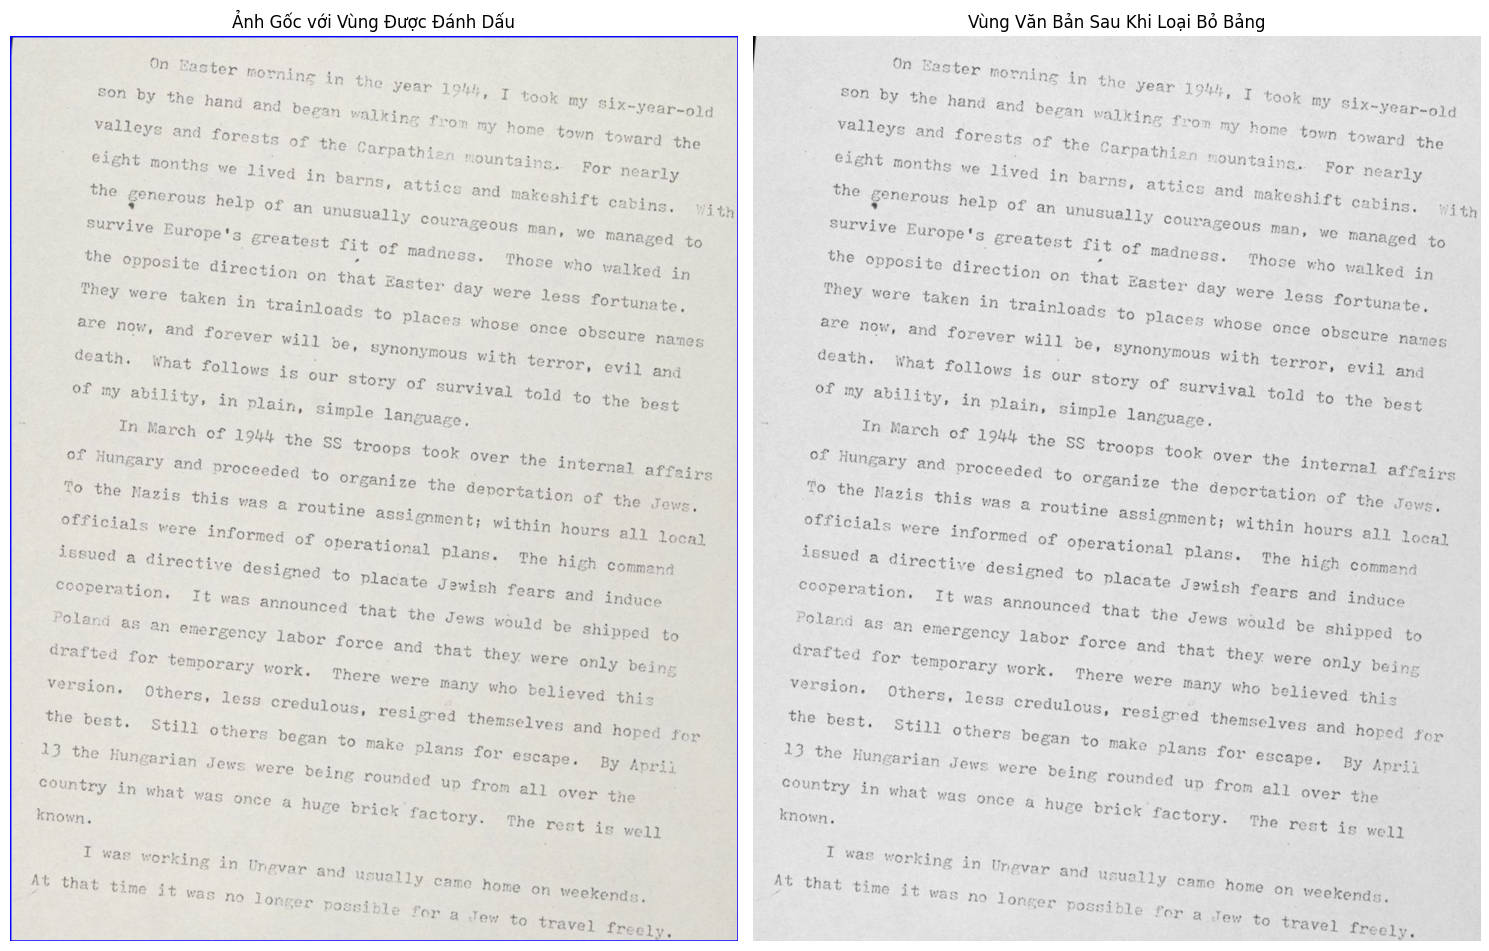

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from docx import Document
from docx.oxml import parse_xml
from docx.oxml.ns import nsdecls

# Bước 1: Đọc ảnh và tiền xử lý
img = cv2.imread('page_01_rotated.JPG', cv2.IMREAD_GRAYSCALE)
original_img = cv2.imread('page_01_rotated.JPG')  # Đọc ảnh màu gốc để hiển thị hình chữ nhật

# Áp dụng threshold để chuyển ảnh thành đen trắng
_, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

# Bước 2: Tìm đường kẻ ngang và dọc để xác định bảng
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))

# Tìm các đường kẻ ngang và dọc
horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# Kết hợp các đường kẻ ngang và dọc để tìm bảng
table_area = cv2.add(horizontal_lines, vertical_lines)

# Bước 3: Tìm các contours (đường viền) để phân chia bảng
contours, hierarchy = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lưu trữ các bounding box của contours để tìm các vùng bảng
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# Loại bỏ contour lớn nhất (toàn bộ bảng lớn)
max_contour = max(bounding_boxes, key=lambda b: b[2] * b[3])
bounding_boxes = [b for b in bounding_boxes if b != max_contour]

# Sắp xếp bounding box theo vị trí (y, x) để giữ đúng thứ tự bảng
bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1], b[0]))

# Bước 4: Vẽ mask để loại bỏ vùng bảng khỏi ảnh gốc
mask = np.zeros_like(img)

# Vẽ các bounding box của bảng lên mask
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(mask, (x, y), (x + w, y + h), (255), thickness=-1)

# Trừ vùng bảng ra khỏi ảnh gốc để lấy phần văn bản
non_table_area = cv2.bitwise_not(mask)
text_area = cv2.bitwise_and(img, img, mask=non_table_area)

# Bước 5: Xử lý các đoạn văn bản riêng biệt
# Tìm các contours trong vùng văn bản
text_contours, _ = cv2.findContours(non_table_area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lưu kết quả của các đoạn văn bản vào danh sách
text_data = []
for contour in text_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 50 and h > 20:  # Bỏ qua các vùng quá nhỏ
        text_img = img[y:y+h, x:x+w]

        # OCR cho đoạn văn bản
        text = pytesseract.image_to_string(text_img, lang='vie').strip()

        # Thêm đoạn văn bản vào danh sách
        text_data.append((x, y, w, h, text))

# Bước 6: Hiển thị các vùng bảng và văn bản với 2 màu khác nhau
output_img = original_img.copy()

# Màu sắc cho các vùng bảng và văn bản
table_color = (0, 255, 0)  # Màu xanh lá cho vùng bảng
text_color = (255, 0, 0)   # Màu đỏ cho vùng văn bản

# Vẽ các vùng bảng với màu xanh lá
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(output_img, (x, y), (x + w, y + h), table_color, 2)

# Vẽ các vùng văn bản với màu đỏ
for (x, y, w, h, text) in text_data:
    cv2.rectangle(output_img, (x, y), (x + w, y + h), text_color, 2)

# Hiển thị các vùng bảng và văn bản
plt.figure(figsize=(15, 10))

# Hiển thị ảnh gốc với hình chữ nhật màu sắc bao quanh các vùng
plt.subplot(1, 2, 1)
plt.title("Ảnh Gốc với Vùng Được Đánh Dấu")
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))  # Chuyển ảnh từ BGR sang RGB cho hiển thị đúng màu
plt.axis('off')

# Hiển thị vùng văn bản còn lại sau khi loại bỏ bảng
plt.subplot(1, 2, 2)
plt.title("Vùng Văn Bản Sau Khi Loại Bỏ Bảng")
plt.imshow(text_area, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
import cv2
import numpy as np
import pytesseract
from docx import Document
from docx.oxml import parse_xml
from docx.oxml.ns import nsdecls

# Bước 1: Đọc ảnh và tiền xử lý
img = cv2.imread('table.jpg', cv2.IMREAD_GRAYSCALE)

# Áp dụng threshold để chuyển ảnh thành đen trắng
_, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

# Bước 2: Tìm đường kẻ ngang và dọc để xác định bảng
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))  # Kernel cho đường ngang
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))   # Kernel cho đường dọc

# Tìm các đường kẻ ngang và dọc
horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# Bước 3: Kết hợp các đường kẻ ngang và dọc để tạo ra vùng bảng
table_area = cv2.add(horizontal_lines, vertical_lines)

# Bước 4: Tìm các contours (đường viền) để phân chia bảng
contours, _ = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lưu trữ các bounding box của contours
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# Loại bỏ contour lớn nhất (toàn bộ bảng lớn)
max_contour = max(bounding_boxes, key=lambda b: b[2] * b[3])
bounding_boxes = [b for b in bounding_boxes if b != max_contour]

# Bước 5: Phủ đen vùng bảng trên ảnh sao chép để xử lý phần văn bản
img_text_only = binary_img.copy()

# Phủ đen các vùng bảng trên ảnh sao chép
for x, y, w, h in bounding_boxes:
    cv2.rectangle(img_text_only, (x, y), (x + w, y + h), (0, 0, 0), -1)  # Phủ đen

# Bước 6: OCR văn bản từ ảnh đã loại bỏ bảng
text_from_image = pytesseract.image_to_string(img_text_only, lang='vie').strip()

# Bước 7: OCR cho từng cell của bảng và lưu kết quả vào danh sách
table_data = []
for idx, (x, y, w, h) in enumerate(bounding_boxes):
    if w > 50 and h > 20:  # Điều chỉnh ngưỡng để bỏ qua các vùng quá nhỏ
        cell_img = img[y:y+h, x:x+w]
        
        # OCR cho cell
        text = pytesseract.image_to_string(cell_img).strip()
        
        # Thêm nội dung vào danh sách dữ liệu bảng
        table_data.append((x, y, w, h, text))

# Bước 8: Tạo file Word và chèn nội dung
doc = Document()

# Chèn văn bản vào file Word
doc.add_heading('Nội dung đoạn văn', level=1)
doc.add_paragraph(text_from_image)

# Tạo bảng trong file Word
rows = len(set([y for _, y, _, _, _ in table_data]))  # Số hàng dựa trên giá trị y
cols = len(set([x for x, _, _, _, _ in table_data]))  # Số cột dựa trên giá trị x

# Tạo bảng trong file Word
table = doc.add_table(rows=rows, cols=cols)

# Chèn nội dung vào các ô của bảng
sorted_table_data = sorted(table_data, key=lambda t: (t[1], t[0]))  # Sắp xếp theo vị trí y (hàng), rồi đến x (cột)
row_idx, col_idx = 0, 0
prev_y = sorted_table_data[0][1]

for idx, (x, y, w, h, text) in enumerate(sorted_table_data):
    # Nếu y thay đổi (tức là sang hàng mới), tăng chỉ số hàng và đặt lại chỉ số cột
    if y != prev_y:
        row_idx += 1
        col_idx = 0
        prev_y = y
    
    # Chèn nội dung vào ô tương ứng
    cell = table.cell(row_idx, col_idx)
    cell.text = text
    
    # Thêm đường viền cho ô
    cell._element.get_or_add_tcPr().append(parse_xml(r'<w:tcBorders {}>'
                                                      r'<w:left w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                      r'<w:right w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                      r'<w:top w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                      r'<w:bottom w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                      r'</w:tcBorders>'.format(nsdecls('w'))))

    col_idx += 1

# Lưu tài liệu thành file .doc
doc.save('output_with_1.docx')

print("Đã lưu nội dung đoạn văn và bảng vào file 'output_with_text_and_table.docx'.")


ValueError: max() arg is an empty sequence

#### code xử lý cho cả đoạn và bảng

In [3]:
import cv2
import numpy as np
import pytesseract
from docx import Document
from docx.oxml import parse_xml
from docx.oxml.ns import nsdecls

# Bước 1: Đọc ảnh và tiền xử lý
img = cv2.imread('table.jpg', cv2.IMREAD_GRAYSCALE)

# Áp dụng threshold để chuyển ảnh thành đen trắng
_, binary_img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)

# Bước 2: Tìm đường kẻ ngang và dọc để xác định bảng
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))  # Kernel cho đường ngang
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))   # Kernel cho đường dọc

# Tìm các đường kẻ ngang và dọc
horizontal_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
vertical_lines = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# Bước 3: Kết hợp các đường kẻ ngang và dọc để tạo ra vùng bảng
table_area = cv2.add(horizontal_lines, vertical_lines)

# Bước 4: Tìm các contours (đường viền) để phân chia bảng
contours, _ = cv2.findContours(table_area, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Lưu trữ các bounding box của contours
bounding_boxes = [cv2.boundingRect(c) for c in contours]

# Kiểm tra xem có bảng hay không
if bounding_boxes:
    # Loại bỏ contour lớn nhất (toàn bộ bảng lớn)
    max_contour = max(bounding_boxes, key=lambda b: b[2] * b[3])
    bounding_boxes = [b for b in bounding_boxes if b != max_contour]

    # Bước 5: Phủ đen vùng bảng trên ảnh sao chép để xử lý phần văn bản
    img_text_only = binary_img.copy()

    # Phủ đen các vùng bảng trên ảnh sao chép
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(img_text_only, (x, y), (x + w, y + h), (0, 0, 0), -1)  # Phủ đen

    # Bước 6: OCR văn bản từ ảnh đã loại bỏ bảng
    text_from_image = pytesseract.image_to_string(img_text_only, lang='vie').strip()

    # Bước 7: OCR cho từng cell của bảng và lưu kết quả vào danh sách
    table_data = []
    for idx, (x, y, w, h) in enumerate(bounding_boxes):
        if w > 50 and h > 20:  # Điều chỉnh ngưỡng để bỏ qua các vùng quá nhỏ
            cell_img = img[y:y+h, x:x+w]
            
            # OCR cho cell
            text = pytesseract.image_to_string(cell_img).strip()
            
            # Thêm nội dung vào danh sách dữ liệu bảng
            table_data.append((x, y, w, h, text))

    # Bước 8: Tạo file Word và chèn nội dung
    doc = Document()

    # Chèn văn bản vào file Word
    doc.add_heading('Nội dung đoạn văn', level=1)
    doc.add_paragraph(text_from_image)

    # Tạo bảng trong file Word
    rows = len(set([y for _, y, _, _, _ in table_data]))  # Số hàng dựa trên giá trị y
    cols = len(set([x for x, _, _, _, _ in table_data]))  # Số cột dựa trên giá trị x

    # Tạo bảng trong file Word
    table = doc.add_table(rows=rows, cols=cols)

    # Chèn nội dung vào các ô của bảng
    sorted_table_data = sorted(table_data, key=lambda t: (t[1], t[0]))  # Sắp xếp theo vị trí y (hàng), rồi đến x (cột)
    row_idx, col_idx = 0, 0
    prev_y = sorted_table_data[0][1]

    for idx, (x, y, w, h, text) in enumerate(sorted_table_data):
        # Nếu y thay đổi (tức là sang hàng mới), tăng chỉ số hàng và đặt lại chỉ số cột
        if y != prev_y:
            row_idx += 1
            col_idx = 0
            prev_y = y
        
        # Chèn nội dung vào ô tương ứng
        cell = table.cell(row_idx, col_idx)
        cell.text = text
        
        # Thêm đường viền cho ô
        cell._element.get_or_add_tcPr().append(parse_xml(r'<w:tcBorders {}>'
                                                          r'<w:left w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                          r'<w:right w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                          r'<w:top w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                          r'<w:bottom w:val="single" w:sz="4" wspace="0" ws="0"/>' 
                                                          r'</w:tcBorders>'.format(nsdecls('w'))))

        col_idx += 1

    # Lưu tài liệu thành file .doc
    doc.save('output_with_text_and_table.docx')
    print("Đã lưu nội dung đoạn văn và bảng vào file 'output_with_text_and_table.docx'.")
else:
    # Nếu không có bảng, chỉ OCR toàn bộ văn bản
    text_from_image = pytesseract.image_to_string(binary_img, lang='vie').strip()
    
    # Tạo file Word và lưu đoạn văn
    doc = Document()
    doc.add_heading('Nội dung đoạn văn', level=1)
    doc.add_paragraph(text_from_image)
    
    # Lưu tài liệu thành file .doc
    doc.save('output_with_text_only.docx')
    print("Đã lưu nội dung đoạn văn vào file 'output_with_text_only.docx'.")


Đã lưu nội dung đoạn văn và bảng vào file 'output_with_text_and_table.docx'.
